In [2]:
import os
import gc
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from  datetime import datetime, timedelta
import gc
import scipy as sp
%matplotlib inline

import torch
from torch.optim import Adam
from torch.nn import MSELoss

from deepseries.models import WaveNet, BasicSeq2Seq
from deepseries.train import Learner
from deepseries.dataset import TimeSeries, Property, Seq2SeqDataLoader
from deepseries.nn.loss import MSELoss, RMSELoss

In [3]:
DIR = "./data"
N_ROWS = 1000
BATCH_SIZE = 128
DROP_BEFORE = 1200

LAGS = [365, 90]
MAX_LAGS = max(LAGS)


ENC_LEN = 28 * 4
DEC_LEN = 28

VALID_LEN = 28
TEST_LEN = 28

TRAIN_LAST_DAY = 1913
USE_SERIES_LEN = TRAIN_LAST_DAY - DROP_BEFORE + 1 + 28

CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "int16", 'snap_TX': 'int16', 'snap_WI': 'int16' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

# FIRST_DAY = datetime(2011, 1, 29) 
# FORECAST_DAY = datetime(2016,4, 25) 

In [4]:
def load_data():
    label_encoders = {}
    
    prices = pd.read_csv(os.path.join(DIR, "sell_prices.csv"), dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(prices[col].astype(str).fillna("None"))
            prices[col] = label_encoders[col].transform(prices[col].astype(str).fillna("None")).astype("int16")
    
    cal = pd.read_csv(os.path.join(DIR, "calendar.csv"), dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(cal[col].astype(str).fillna("None"))
            cal[col] = label_encoders[col].transform(cal[col].astype(str).fillna("None")).astype("int16")
    
    start_day = max(1, DROP_BEFORE-MAX_LAGS)
    numcols = [f"d_{day}" for day in range(start_day, TRAIN_LAST_DAY+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv(os.path.join(DIR, "sales_train_validation.csv"), 
                     usecols = catcols + numcols, dtype = dtype, nrows=N_ROWS)
    
    for col in catcols:
        if col != "id":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(dt[col].astype(str).fillna("None"))
            dt[col] = label_encoders[col].transform(dt[col].astype(str).fillna("None")).astype("int16")

    for day in range(TRAIN_LAST_DAY+1, TRAIN_LAST_DAY+28+1):
        dt[f"d_{day}"] = np.nan
    
    product = dt[catcols].copy()
    print(f"product shape {product.shape}")

    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")

    dt = dt.merge(cal[['d', 'wm_yr_wk']], on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    dt['d'] = dt['d'].str.replace('d_', '').astype("int32")
    price = dt.pivot(index="id", columns="d", values="sell_price")
    xy = dt.pivot(index="id", columns="d", values="sales")
    del dt; gc.collect()
    print(f"sale_xy shape {xy.shape}")
    print(f"price shape {price.shape}")

    cal_use_col = ['date', 'wday', 'month', 'year', 'event_name_1',
    'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
    'snap_WI']
    cal = cal[cal_use_col]
    cal['year'] = cal['year'] - cal['year'].min()
    cal['quarter'] = cal.date.dt.quarter
    cal = cal.drop("date", axis=1).T
    cal = cal[xy.columns]
    print(f"calendar shape {cal.shape}")
    
    submission = pd.read_csv(os.path.join(DIR, "sample_submission.csv"))
    print(f"submisson shape {submission.shape}")
    return xy, price, cal, product, submission

In [5]:
df_xy, df_price, df_calendar, df_product, df_sub = load_data()

product shape (1000, 6)
sale_xy shape (1000, 1107)
price shape (1000, 1107)
calendar shape (11, 1107)
submisson shape (60980, 29)


In [6]:
# series
xy = np.log1p(df_xy.values)
price = np.log1p(df_price.values)

/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  
/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# series state
xy_nan = np.isnan(xy).astype("float32")
xy_zero = (xy == 0).astype("float32")

In [8]:
# series statistics

xy_valid_masked = np.ma.masked_array(xy, mask=xy_nan.astype(bool))

xy_mean = xy_valid_masked.mean(axis=1).data
xy_std = xy_valid_masked.std(axis=1).data
xy_skew = sp.stats.mstats.skew(xy_valid_masked, axis=1).data
xy_kurt = np.clip(sp.stats.mstats.kurtosis(xy_valid_masked, axis=1).data, None, 10)

In [9]:
# series normalization

xy = np.nan_to_num((xy - np.expand_dims(xy_mean, 1)) / (np.expand_dims(xy_std, 1) + 1e-6), 0.).astype("float32")

In [10]:
# series statistic features

xy_mean_mean = xy_mean.mean()
xy_mean_std = xy_mean.std()
xy_std_mean = xy_std.mean()
xy_std_std = xy_std.std()
xy_skew_mean = xy_skew.mean()
xy_skew_std = xy_skew.std()
xy_kurt_mean = xy_kurt.mean()
xy_kurt_std = xy_kurt.std()

f1101_xy_mean = (xy_mean - xy_mean_mean) / xy_mean_std
f1101_xy_std = (xy_std - xy_std_mean) / xy_std_std
f1101_xy_skew = (xy_skew - xy_skew_mean) / xy_skew_std
f1101_xy_kurt = (xy_kurt - xy_kurt_mean) / xy_kurt_std

f1101_xy_statistic = np.stack([f1101_xy_mean, f1101_xy_std, f1101_xy_skew, f1101_xy_kurt], 
                              axis=1).astype("float32")
f1011_xy_stats = np.stack([xy_nan, xy_zero], axis=1).astype("float32")[:, :, MAX_LAGS:]

del f1101_xy_mean; del f1101_xy_std; del f1101_xy_skew; del f1101_xy_kurt; gc.collect()

0

In [11]:
# series lags

def create_lags(xy, n_lags):
    r = []
    for l in n_lags:
        lag = np.zeros_like(xy)
        lag[:, l:] = xy[:, :-l]
        r.append(lag)
    return np.stack(r, axis=1)

f1111_xy_lags = create_lags(xy, LAGS)[:, :, MAX_LAGS:].astype("float32")

In [12]:
# series categorical

f1100_xy_cate = df_product.set_index("id").values.astype("int64")

In [13]:
# series drop nan lag

xy = np.expand_dims(xy, 1)[:, :, MAX_LAGS:]

In [14]:
# calendar feature

def periodic_feature(x, T):
    psin = np.sin(x * np.pi * 2 / T)
    pcos = np.cos(x * np.pi * 2 / T)
    return np.stack([psin, pcos], axis=0)

f1111_date = np.concatenate([
    periodic_feature(df_calendar.T['wday'].values, 7),
    periodic_feature(df_calendar.T['month'].values, 12),
    periodic_feature(df_calendar.T['quarter'].values, 4),
    df_calendar.T[['snap_CA', 'snap_TX', 'snap_WI']].values.T
])
f1111_date = np.expand_dims(f1111_date, 0)[:, :, MAX_LAGS:]


f1110_event = np.expand_dims(
    df_calendar.T[['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']].T.values, 0)[:, :, MAX_LAGS:]

In [15]:
class ForwardSpliter:
    
    def split(self, time_idx, enc_len, dec_len, valid_size):
        if valid_size < 1:
            valid_size = int(np.floor(len(time_idx) * valid_size))
        valid_idx = time_idx[-(valid_size+enc_len):]
        train_idx = time_idx[:-valid_size]
        return train_idx, valid_idx
    
spliter = ForwardSpliter()

train_idx, valid_idx = spliter.split(np.arange(xy.shape[2]), ENC_LEN, DEC_LEN, VALID_LEN+TEST_LEN)
valid_idx, test_idx = spliter.split(valid_idx, ENC_LEN, DEC_LEN, TEST_LEN)

In [16]:
train_xy = TimeSeries(xy[:, :, train_idx])
valid_xy = TimeSeries(xy[:, :, valid_idx])
test_xy = TimeSeries(xy[:, :, test_idx])

train_f1011_xy_stats = TimeSeries(f1011_xy_stats[:, :, train_idx])
valid_f1011_xy_stats = TimeSeries(f1011_xy_stats[:, :, valid_idx])
test_f1011_xy_stats = TimeSeries(f1011_xy_stats[:, :, test_idx])

train_f1101_xy_statistic = Property(f1101_xy_statistic)
valid_f1101_xy_statistic = Property(f1101_xy_statistic)
test_f1101_xy_statistic = Property(f1101_xy_statistic)

train_f1111_xy_lags = TimeSeries(f1111_xy_lags[:, :, train_idx])
valid_f1111_xy_lags = TimeSeries(f1111_xy_lags[:, :, valid_idx])
test_f1111_xy_lags = TimeSeries(f1111_xy_lags[:, :, test_idx])

train_f1100_xy_cate = Property(f1100_xy_cate)
valid_f1100_xy_cate = Property(f1100_xy_cate)
test_f1100_xy_cate = Property(f1100_xy_cate)

train_f1110_event = TimeSeries(f1110_event[:, :, train_idx], idx_map=np.zeros_like(np.arange(df_xy.shape[0])))
valid_f1110_event = TimeSeries(f1110_event[:, :, valid_idx], idx_map=np.zeros_like(np.arange(df_xy.shape[0])))
test_f1110_event = TimeSeries(f1110_event[:, :, test_idx], idx_map=np.zeros_like(np.arange(df_xy.shape[0])))

train_f1111_date = TimeSeries(f1111_date[:, :, train_idx], idx_map=np.zeros_like(np.arange(df_xy.shape[0])))
valid_f1111_date = TimeSeries(f1111_date[:, :, valid_idx], idx_map=np.zeros_like(np.arange(df_xy.shape[0])))
test_f1111_date = TimeSeries(f1111_date[:, :, test_idx], idx_map=np.zeros_like(np.arange(df_xy.shape[0])))

In [17]:
train_dl = Seq2SeqDataLoader(train_xy, 
                             batch_size=BATCH_SIZE, 
                             enc_lens=ENC_LEN, 
                             dec_lens=DEC_LEN, 
                             use_cuda=True, 
                             mode='train', 
                             time_free_space=4,
                             enc_num_feats=[train_f1011_xy_stats, train_f1101_xy_statistic, train_f1111_xy_lags, train_f1111_date], 
                             enc_cat_feats=[train_f1100_xy_cate, train_f1110_event], 
                             dec_num_feats=[train_f1101_xy_statistic, train_f1111_xy_lags, train_f1111_date], 
                             dec_cat_feats=[train_f1100_xy_cate, train_f1110_event],
                             weight=None)

valid_dl = Seq2SeqDataLoader(valid_xy, 
                             batch_size=BATCH_SIZE, 
                             enc_lens=ENC_LEN, 
                             dec_lens=DEC_LEN, 
                             use_cuda=True, 
                             mode='valid', 
                             time_free_space=0,
                             enc_num_feats=[valid_f1011_xy_stats, valid_f1101_xy_statistic, valid_f1111_xy_lags, valid_f1111_date], 
                             enc_cat_feats=[valid_f1100_xy_cate, valid_f1110_event], 
                             dec_num_feats=[valid_f1101_xy_statistic, valid_f1111_xy_lags, valid_f1111_date],
                             dec_cat_feats=[valid_f1100_xy_cate, valid_f1110_event], 
                              )

test_dl = Seq2SeqDataLoader(test_xy, 
                             batch_size=BATCH_SIZE, 
                             enc_lens=ENC_LEN, 
                             dec_lens=DEC_LEN, 
                             use_cuda=True, 
                             mode='test', 
                             time_free_space=0,
                             enc_num_feats=[test_f1011_xy_stats, test_f1101_xy_statistic, test_f1111_xy_lags, test_f1111_date], 
                             enc_cat_feats=[test_f1100_xy_cate, test_f1110_event], 
                             dec_num_feats=[test_f1101_xy_statistic, test_f1111_xy_lags, test_f1111_date],
                             dec_cat_feats=[test_f1100_xy_cate, test_f1110_event],
                      )

In [17]:
model = BasicSeq2Seq(xy_dim=1, hidden_dim=64, enc_num=17, 
                enc_cat=[(3049, 16), (7, 1), (10, 1), (3, 1), (3, 1), (32, 4), (5, 1), (5, 1), (3, 1)],
                dec_num=15,
                dec_cat=[(3049, 16), (7, 1), (10, 1), (3, 1), (3, 1), (32, 4), (5, 1), (5, 1), (3, 1)],
               )
opt = Adam(model.parameters(), 0.001)
loss_fn = RMSELoss()
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 32, eta_min=1e-4)
model.cuda()
learner = Learner(model, opt, loss_fn, './m5_0412_2', log_interval=50, lr_scheduler=lr_scheduler)
learner.fit(50, train_dl, valid_dl, start_save=10, early_stopping=False)

start training >>>>>>>>>>>  see log: tensorboard --logdir ./m5_0412_2\logs
epoch 1 / 50, batch 100%, train loss 1.0407, valid loss 1.0334, cost time 0.6 minute
epoch 2 / 50, batch 100%, train loss 0.9938, valid loss 1.0341, cost time 0.6 minute
epoch 3 / 50, batch 100%, train loss 0.9959, valid loss 1.0294, cost time 0.6 minute
epoch 4 / 50, batch 100%, train loss 1.0322, valid loss 1.0290, cost time 0.6 minute
epoch 5 / 50, batch 100%, train loss 1.0076, valid loss 1.0285, cost time 0.6 minute
epoch 6 / 50, batch 100%, train loss 1.0155, valid loss 1.0284, cost time 0.6 minute
epoch 7 / 50, batch  12%, train loss 1.0186
epoch 7 / 50, batch 100%, train loss 1.0083, valid loss 1.0280, cost time 0.6 minute
epoch 8 / 50, batch 100%, train loss 0.9887, valid loss 1.0292, cost time 0.6 minute
epoch 9 / 50, batch 100%, train loss 1.0188, valid loss 1.0247, cost time 0.6 minute
epoch 10 / 50, batch 100%, train loss 0.9957, valid loss 1.0186, cost time 0.6 minute
epoch 11 / 50, batch 100%, tra

In [177]:
def predict_submission(model, test_dl):
    model.eval()
    test_dl.test()
    preds = []
    for batch in test_dl:
        preds.append(model.predict(**batch).cpu().detach().numpy())
    preds = np.concatenate(preds, axis=0).squeeze()
    preds = np.expm1(preds * (np.expand_dims(xy_std, 1) + 1e-6) + np.expand_dims(xy_mean, 1))
    return preds

preds = predict_submission(learner.model, test_dl)

In [191]:
df_xy.fillna(0).mean(axis=1).mean()

1.0343604336043353

In [ ]:
xy = np.log1p(df_xy.values)

In [175]:
preds = np.concatenate(preds, axis=0).squeeze()

In [179]:
preds.mean()

0.8093986224446256

In [188]:
np.expm1(0.8)

1.2255409284924679

In [183]:
top1.iloc[:, 1:].mean(axis=1).mean()

1.195302906349722

In [187]:
df_xy.iloc[:1000].mean(axis=1).mean()

1.1056177987127973

In [174]:
for i in preds:
    print(i.shape)

(128, 1, 28)
(128, 1, 28)
(128, 1, 28)
(128, 1, 28)
(128, 1, 28)
(128, 1, 28)
(128, 1, 28)
(104, 1, 28)


In [100]:
top1 = pd.read_csv("./data/submission_top1.csv")
top1 = top1.loc[top1.id.isin(df_xy.index)]
top2 = pd.read_csv("./data/submission_top2.csv")
top2 = top2.loc[top2.id.isin(df_xy.index)]

In [135]:
np.log1p(df_xy).mean(axis=1).mean()

C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


0.45861664408935415

In [119]:
xy_mean.mean()

0.45861664408935404

In [123]:
xy = np.log1p(df_xy.values)
print(xy.mean())

C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


nan


In [130]:
pd.DataFrame(xy).mean(axis=1).mean()

0.45861664408935415

In [127]:
df_xy

d,835,836,837,838,839,840,841,842,843,844,...,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOBBIES_1_002_CA_1_validation,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOBBIES_1_003_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOBBIES_1_004_CA_1_validation,0.0,2.0,3.0,7.0,0.0,0.0,2.0,1.0,2.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOBBIES_1_005_CA_1_validation,1.0,0.0,1.0,0.0,1.0,1.0,5.0,4.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_1_440_CA_1_validation,3.0,3.0,1.0,0.0,2.0,1.0,1.0,5.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOUSEHOLD_1_441_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOUSEHOLD_1_442_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


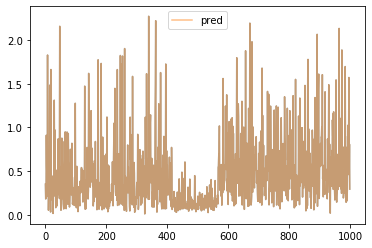

In [158]:
plt.plot(np.log1p(df_xy).mean(axis=1).values, alpha=0.5)
plt.plot(xy_mean, label='pred', alpha=0.5)
plt.legend()

In [139]:
def plot(idx):
    plt.figure(figsize=(16, 5))
    plt.plot(df_xy.iloc[idx, -56:-28].values)
    plt.plot(np.arange(28, 56), preds[idx], label='wave')
    plt.plot(np.arange(28, 56), top1.iloc[idx, 1:].values, label='top1')
    plt.plot(np.arange(28, 56), top2.iloc[idx, 1:].values, label='top2')
    plt.legend()
    plt.title(f"idx {idx}")

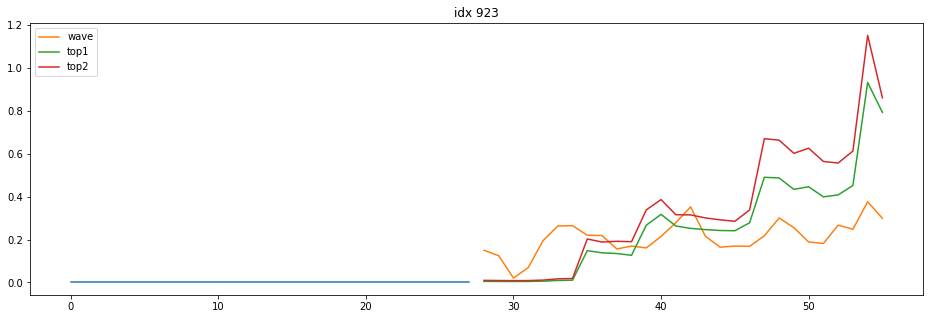

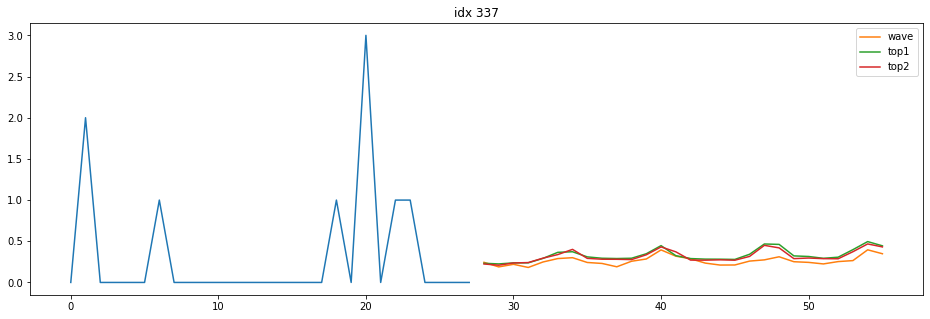

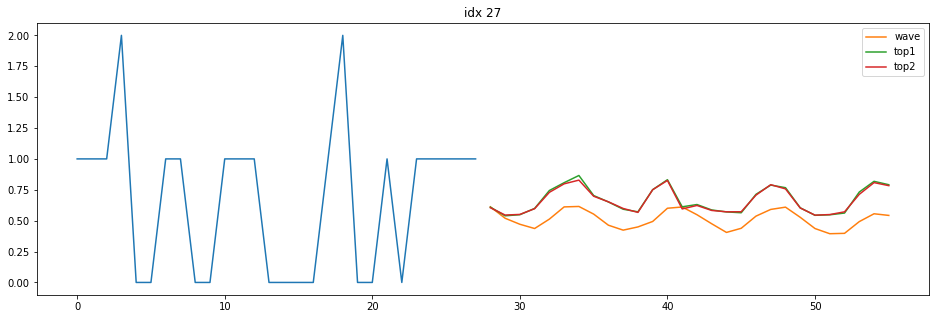

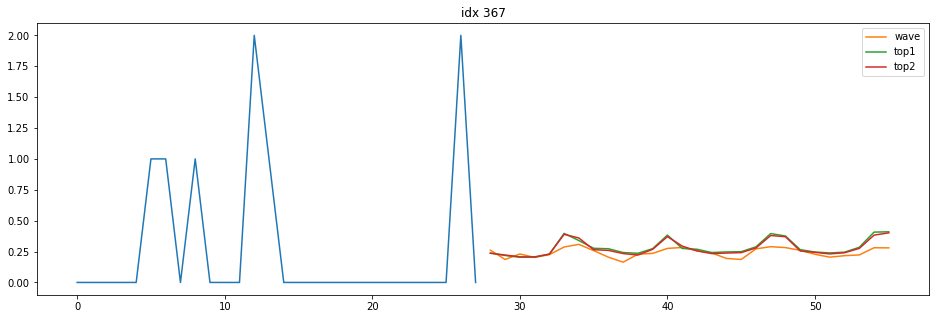

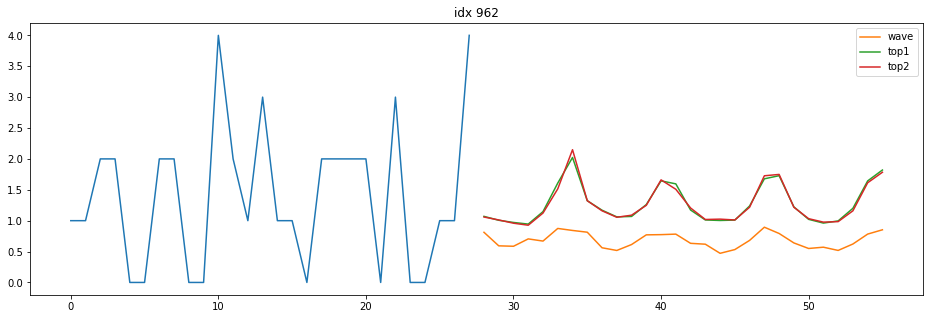

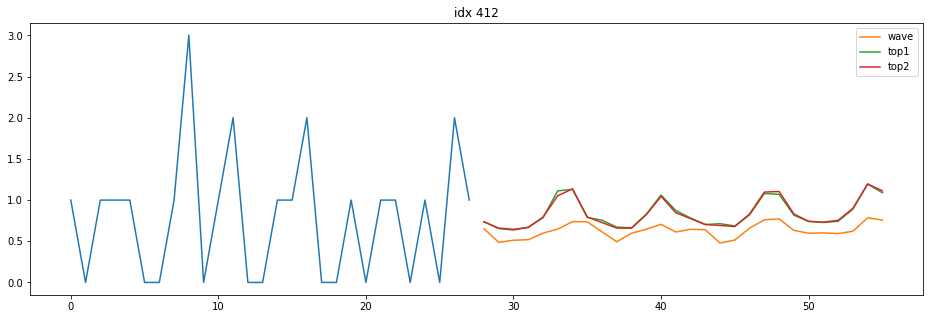

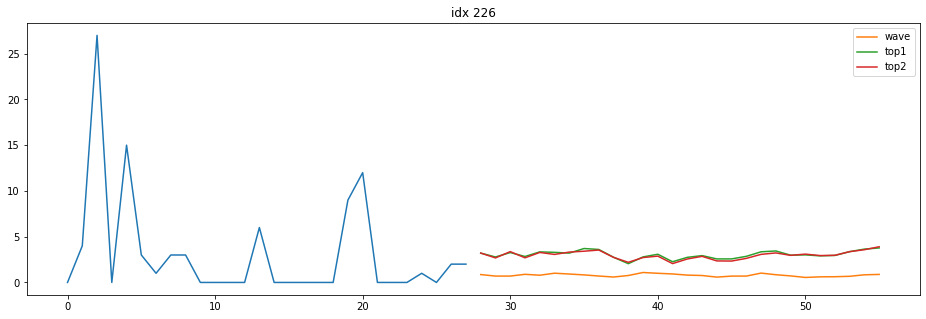

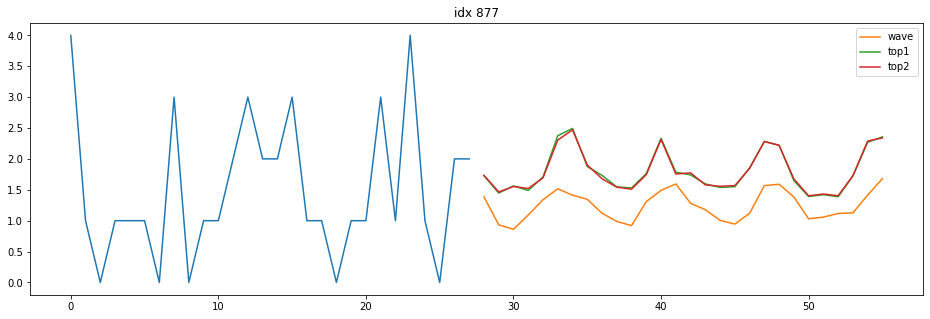

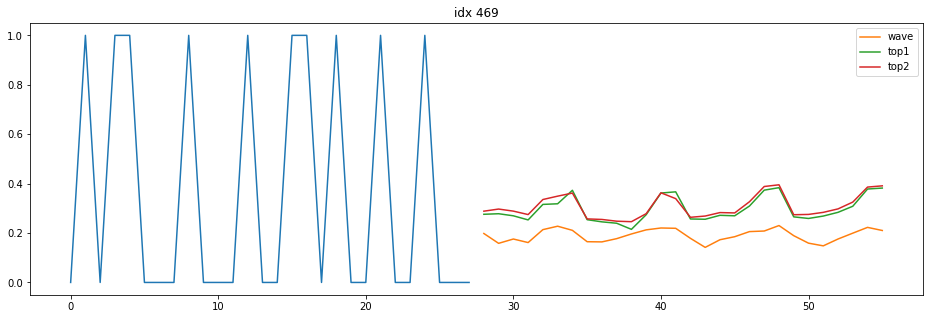

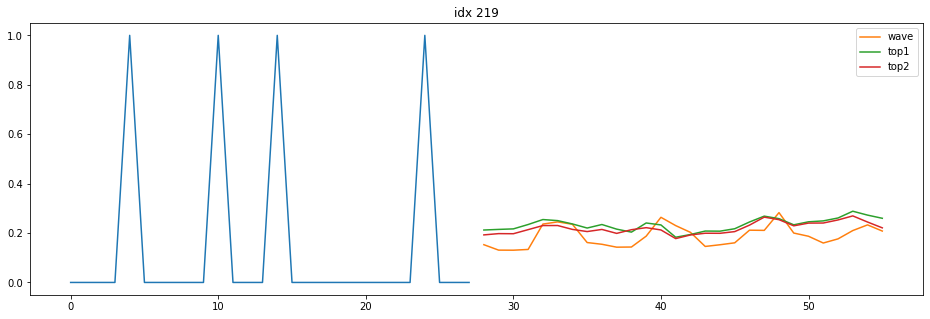

In [192]:
for i in np.random.randint(0, 1000, 10):
    plot(i)

In [202]:
df_xy.isnull().reset_index().sum(axis=1).sort_values()

429     28
555     28
556     28
557     28
558     28
      ... 
719    720
832    720
801    748
547    818
996    867
Length: 1000, dtype: int64

In [220]:
rate = preds.mean(axis=1) / top1.mean(axis=1).values

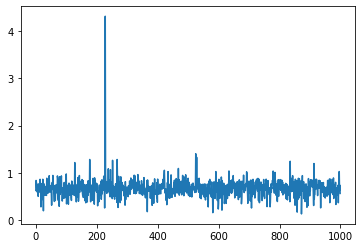

In [221]:
plt.plot(rate)

In [224]:
df_xy.isnull().mean(axis=1).values

array([0.08130081, 0.02529359, 0.26467931, 0.02529359, 0.02529359,
       0.02529359, 0.02529359, 0.02529359, 0.02529359, 0.02529359,
       0.02529359, 0.02529359, 0.02529359, 0.02529359, 0.02529359,
       0.02529359, 0.02529359, 0.02529359, 0.02529359, 0.02529359,
       0.02529359, 0.02529359, 0.02529359, 0.02529359, 0.02529359,
       0.25203252, 0.27732611, 0.02529359, 0.02529359, 0.02529359,
       0.02529359, 0.02529359, 0.13821138, 0.02529359, 0.02529359,
       0.02529359, 0.02529359, 0.02529359, 0.02529359, 0.02529359,
       0.02529359, 0.02529359, 0.02529359, 0.02529359, 0.42276423,
       0.55555556, 0.02529359, 0.02529359, 0.02529359, 0.02529359,
       0.02529359, 0.02529359, 0.02529359, 0.1129178 , 0.02529359,
       0.02529359, 0.02529359, 0.02529359, 0.02529359, 0.02529359,
       0.04336043, 0.02529359, 0.02529359, 0.02529359, 0.09394761,
       0.02529359, 0.02529359, 0.02529359, 0.02529359, 0.02529359,
       0.02529359, 0.02529359, 0.02529359, 0.02529359, 0.02529

In [225]:
ana = pd.DataFrame({"rate": rate, "null_rate": df_xy.isnull().mean(axis=1).values})

In [227]:
ana.corr()

,rate,null_rate
rate,1.000000,-0.045246
null_rate,-0.045246,1.000000


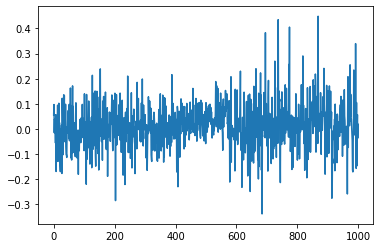

In [231]:
plt.plot(train_xy.values.squeeze().mean(axis=1))

In [232]:
train_xy.values.squeeze().mean(axis=1).mean()

0.011393056

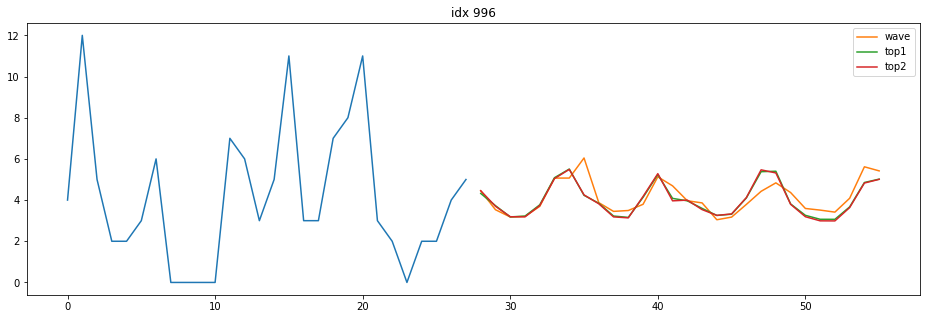

In [206]:
plot(996)

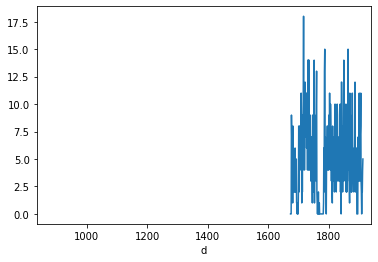

In [204]:
df_xy.iloc[996].plot()

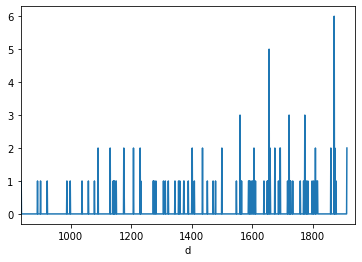

In [203]:
df_xy.iloc[429].plot()

In [194]:
df_xy.iloc[152].describe()

count    1079.000000
mean        0.874884
std         0.957399
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: HOBBIES_1_157_CA_1_validation, dtype: float64

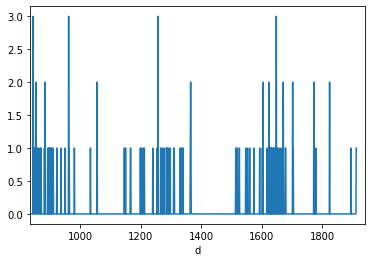

In [195]:
df_xy.iloc[770].plot()

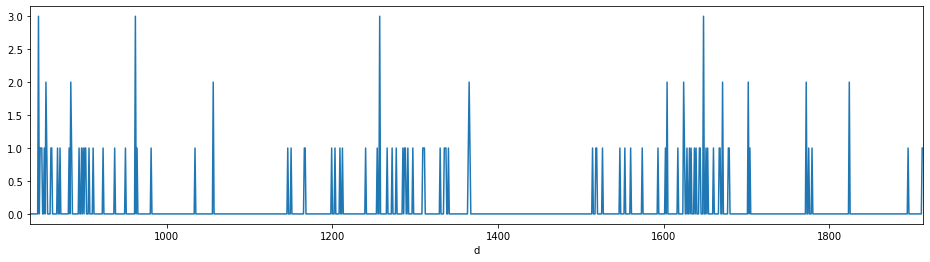

In [196]:
df_xy.iloc[770].iloc[:-28].plot(figsize=(16, 4))

In [197]:
df_xy.iloc[770].describe()

count    1079.000000
mean        0.107507
std         0.369939
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: HOUSEHOLD_1_210_CA_1_validation, dtype: float64

In [198]:
df_xy.iloc[770].isnull().sum()

28

In [199]:
df_xy.iloc[219].isnull().sum()

28

In [151]:
df_xy.iloc[152].mean()

0.8748841519925857

In [155]:
preds[152].mean()

0.7506047597659338

In [162]:
df_xy

d,835,836,837,838,839,840,841,842,843,844,...,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOBBIES_1_002_CA_1_validation,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOBBIES_1_003_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOBBIES_1_004_CA_1_validation,0.0,2.0,3.0,7.0,0.0,0.0,2.0,1.0,2.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOBBIES_1_005_CA_1_validation,1.0,0.0,1.0,0.0,1.0,1.0,5.0,4.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_1_440_CA_1_validation,3.0,3.0,1.0,0.0,2.0,1.0,1.0,5.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOUSEHOLD_1_441_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOUSEHOLD_1_442_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
df_xy.mean(axis=1).mean()

1.1056177987127973

In [167]:
np.log1p(df_xy).mean(axis=1).mean()

C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


0.45861664408935415

In [171]:
preds.mean()

0.8079887441912121